# Анализ данных страхования (insurance.csv)

In [44]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, pointbiserialr, chi2_contingency, levene, shapiro, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [45]:
# Загрузка данных
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [46]:
# Преобразуем категориальные переменные в числовые, где нужно
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df['sex'] = df['sex'].map({'male': 1, 'female': 0})

## 1. Корреляция со стоимостью страховки (charges)

Проверка нормальности (тест Шапиро-Уилка, H0: распределение нормально):
age: W = 0.9447, p = 5.69e-22 → не нормально
bmi: W = 0.9939, p = 2.60e-05 → не нормально
children: W = 0.8232, p = 5.07e-36 → не нормально
charges: W = 0.8147, p = 1.15e-36 → не нормально


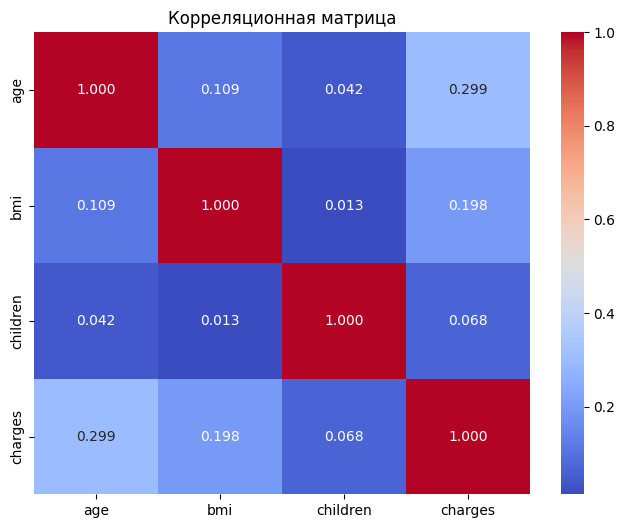

In [47]:
# Выделим количественные переменные
quant_vars = ['age', 'bmi', 'children', 'charges']

normality_results = []

print("Проверка нормальности (тест Шапиро-Уилка, H0: распределение нормально):")
for var in quant_vars:
    stat, p = shapiro(df[var])
    is_normal = p > 0.05
    normality_results.append({
        'Переменная': var,
        'W-статистика': stat,
        'p-value': p,
        'Нормально?': is_normal
    })
    print(f"{var}: W = {stat:.4f}, p = {p:.2e} → {'нормально' if is_normal else 'не нормально'}")
    
# Корреляционная матрица Пирсона
corr_matrix = df[quant_vars].corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Корреляционная матрица')
plt.show()

In [48]:
# Сравнение коэффициентов корреляции с charges
results = []
for var in ['age', 'bmi', 'children']:
    # Пирсон
    pear_r, pear_p = pearsonr(df[var], df['charges'])
    # Спирмен
    spear_r, spear_p = spearmanr(df[var], df['charges'])
    results.append({
        'Переменная': var,
        'Пирсон r': pear_r,
        'Пирсон p': pear_p,
        'Спирмен r': spear_r,
        'Спирмен p': spear_p
    })

corr_df = pd.DataFrame(results)
corr_df

,Переменная,Пирсон r,Пирсон p,Спирмен r,Спирмен p
0,age,0.299008,4.886693e-29,0.534392,1.130692e-99
1,bmi,0.198341,2.459086e-13,0.119396,1.192606e-05
2,children,0.067998,1.285213e-02,0.133339,9.846806e-07


In [49]:
# Корреляция с бинарной переменной smoker
pb_r, pb_p = pointbiserialr(df['smoker'], df['charges'])
print(f"Точечно-бисериальная корреляция (smoker vs charges): r = {pb_r:.4f}, p = {pb_p:.2e}")

Точечно-бисериальная корреляция (smoker vs charges): r = 0.7873, p = 8.27e-283


In [50]:
# Вывод трёх наиболее коррелирующих переменных с charges
all_corr = []

# Количественные
for var in ['age', 'bmi', 'children']:
    r, p = pearsonr(df[var], df['charges'])
    all_corr.append((var, abs(r), p))

# smoker
all_corr.append(('smoker', abs(pb_r), pb_p))

# Сортировка по модулю коэффициента
all_corr_sorted = sorted(all_corr, key=lambda x: x[1], reverse=True)
print("Топ-3 переменных, наиболее коррелирующих с charges:")
for var, r, p in all_corr_sorted[:3]:
    print(f"{var}: |r| = {r:.4f}, p = {p:.2e}")

Топ-3 переменных, наиболее коррелирующих с charges:
smoker: |r| = 0.7873, p = 8.27e-283
age: |r| = 0.2990, p = 4.89e-29
bmi: |r| = 0.1983, p = 2.46e-13


## 2. Связь между полом (sex) и курением (smoker)

In [51]:
# Восстановим оригинальные метки для chi2
df_raw = pd.read_csv('insurance.csv')

# Таблица сопряженности
cont_table = pd.crosstab(df_raw['sex'], df_raw['smoker'])
cont_table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [52]:
# Хи-квадрат тест
chi2, p, _, _ = chi2_contingency(cont_table)
print(f"Хи-квадрат = {chi2:.3f}, p = {p:.4f}")

if p < 0.05:
    print("Есть статистически значимая связь между полом и курением.")
else:
    print("Нет статистически значимой связи между полом и курением.")

Хи-квадрат = 7.393, p = 0.0065
Есть статистически значимая связь между полом и курением.


## 3. Однофакторный дисперсионный анализ (ANOVA)

Курящие: W = 0.940, p = 3.62e-09
Некурящие: W = 0.873, p = 1.45e-28
Levene: W = 332.614, p = 1.56e-66
ANOVA (smoker): F = 2177.61, p = 8.27e-283


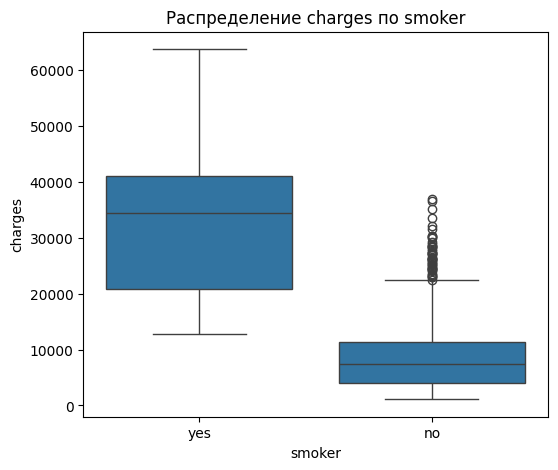

In [53]:
# 3.1. Фактор: курение (smoker)
non_smokers = df[df['smoker'] == 0]['charges']
smokers = df[df['smoker'] == 1]['charges']

# Проверка нормальности (Shapiro-Wilk)
shap_smoke = shapiro(smokers)
shap_nonsmoke = shapiro(non_smokers)
print(f"Курящие: W = {shap_smoke[0]:.3f}, p = {shap_smoke[1]:.2e}")
print(f"Некурящие: W = {shap_nonsmoke[0]:.3f}, p = {shap_nonsmoke[1]:.2e}")

# Проверка гомогенности дисперсий (Levene)
levene_stat, levene_p = levene(smokers, non_smokers)
print(f"Levene: W = {levene_stat:.3f}, p = {levene_p:.2e}")

# ANOVA
f_stat, p_val = f_oneway(smokers, non_smokers)
print(f"ANOVA (smoker): F = {f_stat:.2f}, p = {p_val:.2e}")

# Визуализация
plt.figure(figsize=(6, 5))
sns.boxplot(x=df_raw['smoker'], y=df['charges'])
plt.title('Распределение charges по smoker')
plt.show()

Проверка нормальности по группам BMI:
Группа low: W = 0.908, p = 7.13e-16
Группа medium: W = 0.820, p = 5.01e-22
Группа high: W = 0.804, p = 9.58e-23
Levene (BMI): W = 29.886, p = 2.01e-13
ANOVA (BMI): F = 25.70, p = 1.12e-11


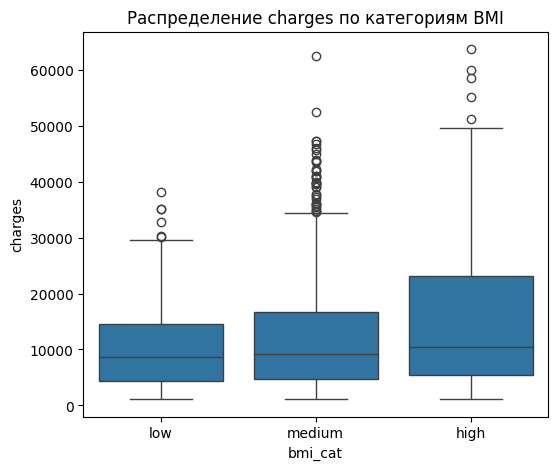

In [54]:
# 3.2. Фактор: BMI — разобьём на 3 категории
df['bmi_cat'] = pd.qcut(df['bmi'], q=3, labels=['low', 'medium', 'high'])

groups_bmi = [df[df['bmi_cat'] == cat]['charges'] for cat in ['low', 'medium', 'high']]

# Проверки
print("Проверка нормальности по группам BMI:")
for i, group in enumerate(groups_bmi):
    w, p = shapiro(group)
    print(f"Группа {['low','medium','high'][i]}: W = {w:.3f}, p = {p:.2e}")

levene_bmi = levene(*groups_bmi)
print(f"Levene (BMI): W = {levene_bmi[0]:.3f}, p = {levene_bmi[1]:.2e}")

# ANOVA
f_bmi, p_bmi = f_oneway(*groups_bmi)
print(f"ANOVA (BMI): F = {f_bmi:.2f}, p = {p_bmi:.2e}")

# Визуализация
plt.figure(figsize=(6, 5))
sns.boxplot(x=df['bmi_cat'], y=df['charges'])
plt.title('Распределение charges по категориям BMI')
plt.show()

Проверка нормальности по возрастным группам:
Группа young: W = 0.698, p = 1.54e-29
Группа middle: W = 0.698, p = 3.13e-26
Группа old: W = 0.695, p = 1.09e-26
Levene (age): W = 0.164, p = 8.48e-01
ANOVA (age): F = 54.36, p = 2.02e-23


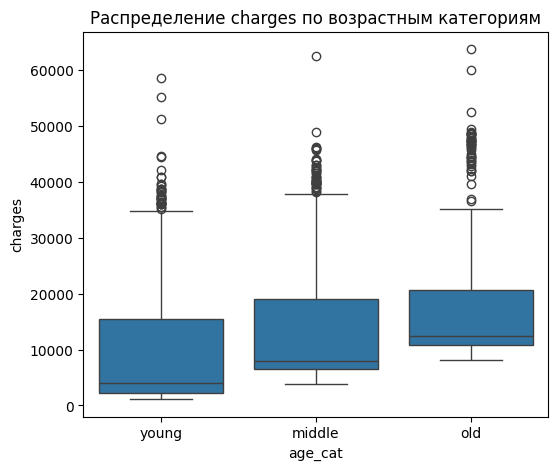

In [55]:
# 3.3. Фактор: возраст — 3 категории
df['age_cat'] = pd.cut(df['age'], bins=3, labels=['young', 'middle', 'old'])

groups_age = [df[df['age_cat'] == cat]['charges'] for cat in ['young', 'middle', 'old']]

# Проверки
print("Проверка нормальности по возрастным группам:")
for i, group in enumerate(groups_age):
    w, p = shapiro(group)
    print(f"Группа {['young','middle','old'][i]}: W = {w:.3f}, p = {p:.2e}")

levene_age = levene(*groups_age)
print(f"Levene (age): W = {levene_age[0]:.3f}, p = {levene_age[1]:.2e}")

# ANOVA
f_age, p_age = f_oneway(*groups_age)
print(f"ANOVA (age): F = {f_age:.2f}, p = {p_age:.2e}")

# Визуализация
plt.figure(figsize=(6, 5))
sns.boxplot(x=df['age_cat'], y=df['charges'])
plt.title('Распределение charges по возрастным категориям')
plt.show()

## 4. Двухфакторный дисперсионный анализ: smoker × sex

In [56]:
# Подготовим данные
df_anova2 = df[['charges', 'smoker', 'sex']].copy()
df_anova2['smoker'] = df_anova2['smoker'].map({0: 'no', 1: 'yes'})
df_anova2['sex'] = df_anova2['sex'].map({0: 'female', 1: 'male'})

# Модель
model = ols('charges ~ C(smoker) + C(sex) + C(smoker):C(sex)', data=df_anova2).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(smoker),1.208777e+11,1.0,2177.284440,1.247285e-282
C(sex),1.421312e+06,1.0,0.025601,8.729026e-01
C(smoker):C(sex),4.923397e+08,1.0,8.868165,2.954255e-03
Residual,7.406056e+10,1334.0,NaN,NaN


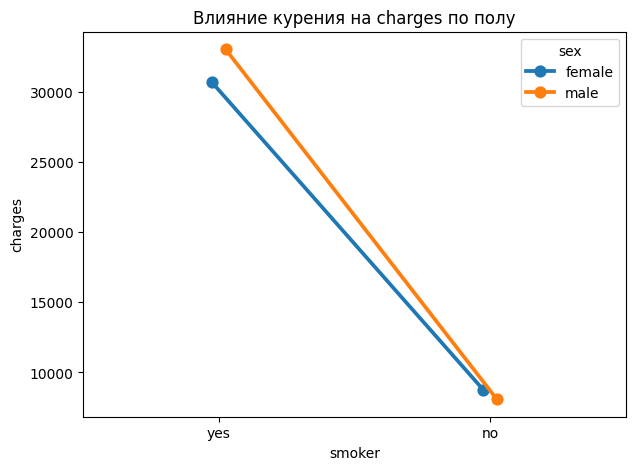

In [57]:
# Визуализация взаимодействия
plt.figure(figsize=(7, 5))
sns.pointplot(data=df_anova2, x='smoker', y='charges', hue='sex', errorbar=None, dodge=True)
plt.title('Влияние курения на charges по полу')
plt.show()